#**Exploring RNA-seq data**
###Master's thesis "Investigating the transcriptional effects of divergent CTCF orthologs using RNA-seq" 
###H. Scherrer

R script to explore RNA-seq data set of 
* G4 WT cells (WT.G4)
* OsTir1/CTCF-AID WT cells (WT.AID.B11)
* OsTir1/CTCF-AID depleted cells (CTCF.AID.AUX) 

Script is representative for exploration of RNA-seq data set compromising  
OsTir1/CTCF-AID WT cells (untreated), OsTir1/CTCF-AID depleted cells (auxin-treated),
*Ciona robusta* CTCF ortholog replacement cells (auxin-treated), *Danio rerio* CTCF ortholog replacement cells (auxin-treated)

#####First load required packages

In [ ]:
library(pheatmap)
library(stats)
library(ggplot2)
library(ggfortify)
library(corrplot)

#####Provide information sheet of samples

In [9]:
colData <- read.table('colData.tsv', header = T, sep = '\t', stringsAsFactors = TRUE, row.names = 'sample_type')
print(colData)

                           group       IAA condition
WT.G4.rep1            WT_control untreated        WT
WT.G4.rep2            WT_control untreated        WT
WT.AID.B11.rep1   no_IAA_control untreated    mutant
WT.AID.B11.rep2   no_IAA_control untreated    mutant
CTCF.AID.AUX.rep1 CTCF_depletion   treated    mutant
CTCF.AID.AUX.rep2 CTCF_depletion   treated    mutant


#####Import TPM-normalized count matrix

In [4]:
tpm <- read.table('TPM_counts_from_SALMON.genes.tsv', header = T, sep = '\t', row.names = 'Name')
tpm <- subset(tpm, select = -c(row.names))
tpm <- as.matrix(tpm)
summary(tpm)

   WT.G4.rep1          WT.G4.rep2        WT.AID.B11.rep1    WT.AID.B11.rep2   
 Min.   :    0.000   Min.   :    0.000   Min.   :    0.00   Min.   :    0.00  
 1st Qu.:    0.000   1st Qu.:    0.000   1st Qu.:    0.00   1st Qu.:    0.00  
 Median :    0.031   Median :    0.088   Median :    0.04   Median :    0.08  
 Mean   :    8.540   Mean   :    8.540   Mean   :    8.54   Mean   :    8.54  
 3rd Qu.:    1.334   3rd Qu.:    1.347   3rd Qu.:    1.23   3rd Qu.:    1.21  
 Max.   :25579.100   Max.   :27365.000   Max.   :31716.90   Max.   :35180.70  
 CTCF.AID.AUX.rep1   CTCF.AID.AUX.rep2  
 Min.   :    0.000   Min.   :    0.000  
 1st Qu.:    0.000   1st Qu.:    0.000  
 Median :    0.078   Median :    0.025  
 Mean   :    8.540   Mean   :    8.540  
 3rd Qu.:    1.295   3rd Qu.:    1.147  
 Max.   :28269.600   Max.   :30503.900  

#####Remove genes in 'tpm' with no reads

In [5]:
tpm[tpm == 0] <- NA
tpm_filtered <- tpm[!rowSums(!is.finite(tpm)),]

#####Compute PCA with the top 500 genes (variance)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5       PC6
Standard deviation     8.0267 4.2522 1.92253 1.74111 1.45694 1.099e-14
Proportion of Variance 0.7052 0.1979 0.04046 0.03318 0.02323 0.000e+00
Cumulative Proportion  0.7052 0.9031 0.94358 0.97677 1.00000 1.000e+00

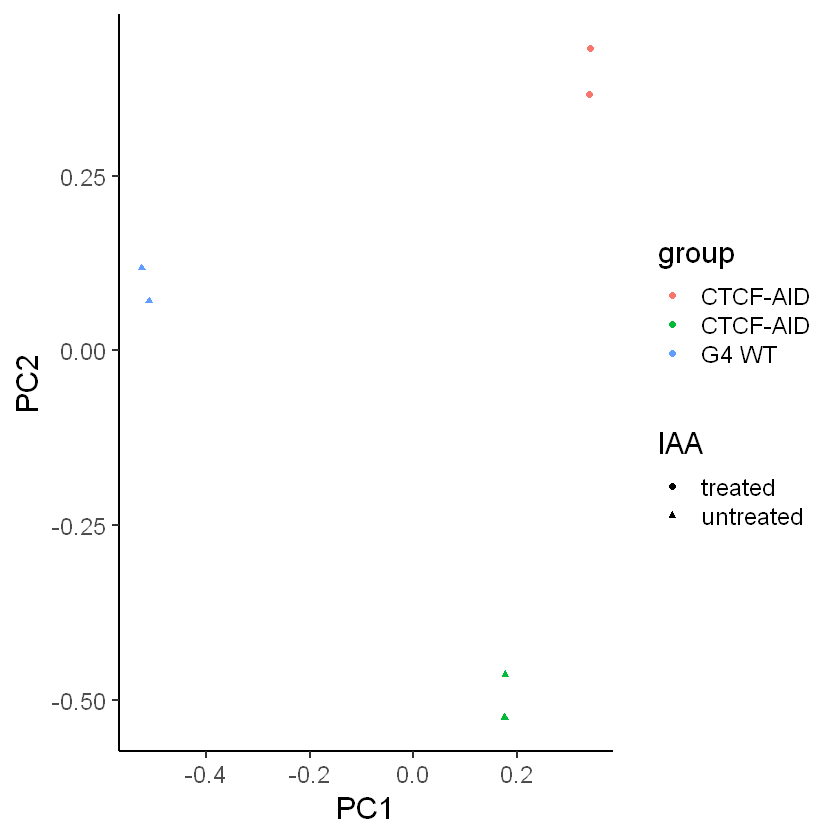

In [10]:
vars <- apply(tpm_filtered, 1, var)
top500 <- names(vars[order(vars, decreasing = T)][1:500])
mtrans <- t(tpm_filtered[top500,])
mtrans <- log2(mtrans + 1)
pca <- prcomp(mtrans)
autoplot(pca, data = colData, colour = 'group', shape = 'IAA') + theme_classic(base_size = 18) + 
  labs(x="PC1", y = "PC2") +
  scale_colour_discrete(labels = c("CTCF-AID", "CTCF-AID", "G4 WT"))
summary(pca)


#####Calculate and plot correlation matrix

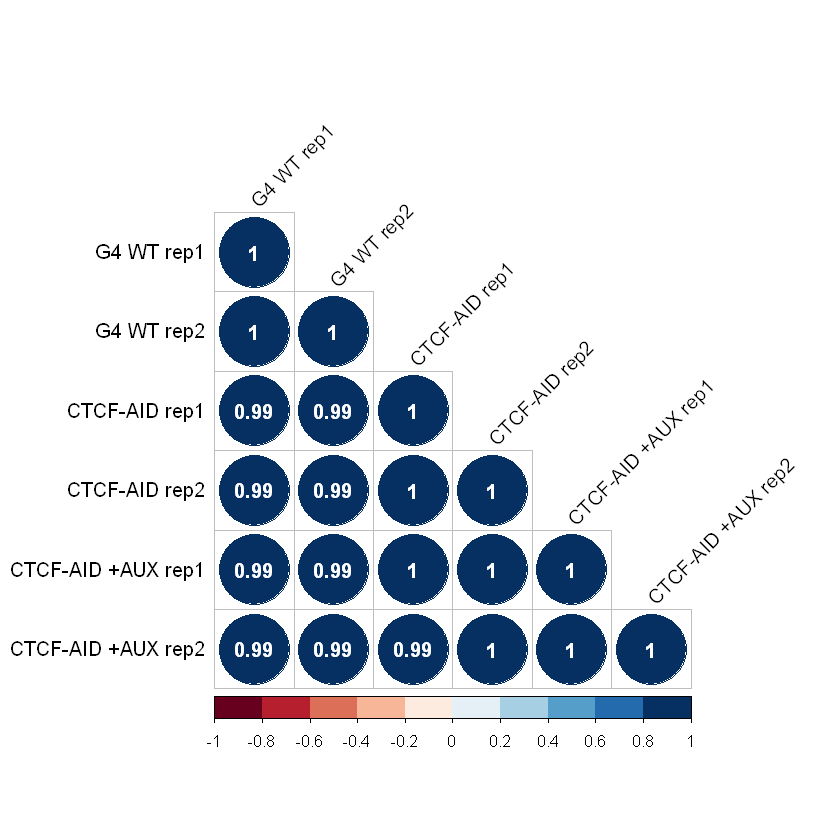

In [11]:
correlation <- cor(tpm_filtered)
colnames(correlation) <- c("G4 WT rep1", "G4 WT rep2", "CTCF-AID +AUX rep1", "CTCF-AID +AUX rep2", "CTCF-AID rep1", "CTCF-AID rep2")
rownames(correlation) <- c("G4 WT rep1", "G4 WT rep2", "CTCF-AID +AUX rep1", "CTCF-AID +AUX rep2", "CTCF-AID rep1", "CTCF-AID rep2")
corrplot(correlation,type = 'lower', method = 'circle', order = 'hclust',
         tl.col = 'black', cl.ratio = 0.2, addCoef.col = 'white', tl.srt = 45,
         col = COL2('RdBu', 10))

####**Explore a single gene expression with DESeq2 data**

In [ ]:
library(DESeq2)

#####Import raw count matrix (Salmon)

In [12]:
counts <- as.matrix(read.table('counts_from_SALMON.genes.tsv', header = T, sep = '\t'))

In [13]:
all(rownames(colData) == colnames(counts))

[1] TRUE

#####Construct the DEseq2 data set object

In [ ]:
dds <- DESeqDataSetFromMatrix(countData = counts, 
                              colData = colData, 
                              design = ~ group)

#####Filter out genes with no reads

In [16]:
dds <- dds[rowSums(DESeq2::counts(dds)) >= 1,]

#####Run differential expression analysis

In [ ]:
dds <- DESeq(dds)

####Plot counts of single gene (CTCF)

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



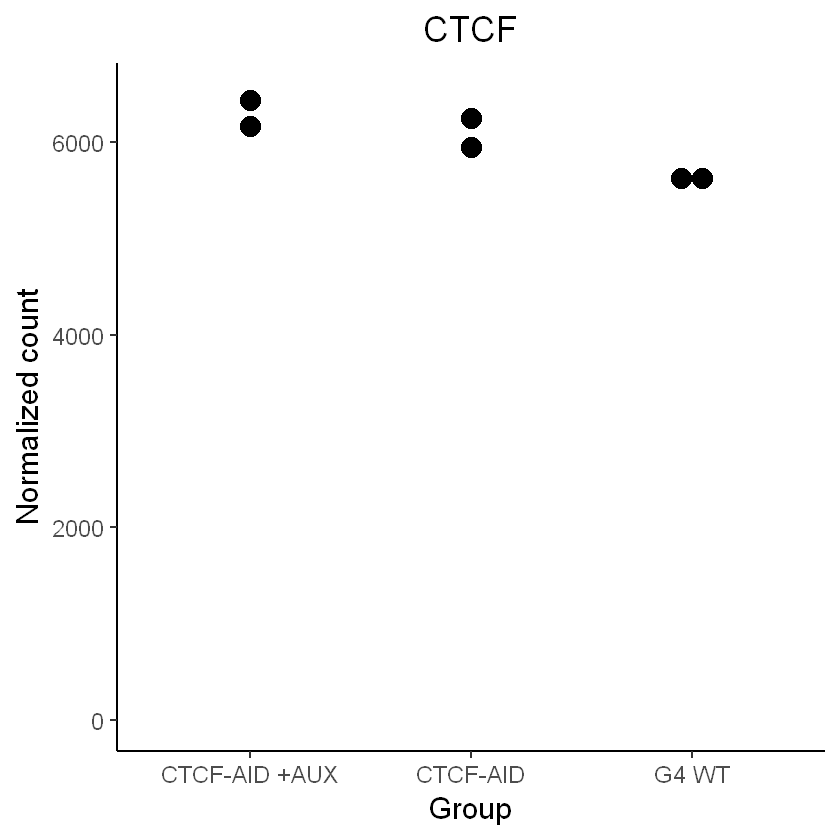

In [25]:
plot_CTCF_controls <- plotCounts(dds, gene = 'ENSMUST00000005841.15',
           intgroup = c('group', 'condition'), returnData=TRUE) 

ggplot(plot_CTCF_controls, aes(x=group, y=count)) + geom_dotplot(binaxis='y', stackdir='center')+
  theme_classic(base_size = 18) +
  labs(x="Group", y = "Normalized count")+
  ylim(0,6500)+
  scale_x_discrete(labels=c("CTCF_depletion" = "CTCF-AID +AUX", "no_IAA_control" = "CTCF-AID",
                            "WT_control" = "G4 WT"))+
  ggtitle("CTCF") + theme(plot.title = element_text(hjust = 0.5))
